# Classical Bayesian optimisation

In [2]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

In [8]:
key = jax.random.PRNGKey(31415)
key_init_params, key_run = jax.random.split(key)

## Eval experiments

In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ branin

*** Running branin ***
Eval VBLL-greedy
Eval VBLL
Eval GP


In [439]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ hartmann

*** Running hartmann ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 15min 13s, sys: 55 s, total: 16min 8s
Wall time: 2min 20s


In [440]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley2

*** Running ackley2 ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 15min 2s, sys: 52.4 s, total: 15min 55s
Wall time: 2min 11s


In [441]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley5

*** Running ackley5 ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 14min 56s, sys: 48.7 s, total: 15min 45s
Wall time: 3min 18s


## Plot results

In [454]:
res_files = !ls *pkl
res_files = res_files

In [444]:
res = {}
for file in res_files:
    res_experiment = pd.read_pickle(file)
    res[file.rstrip(".pkl")] = res_experiment

In [748]:
def format_ticks(ax):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))  # 5 major ticks on X-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))  # 4 major ticks on Y-axis
    ax.minorticks_on()    

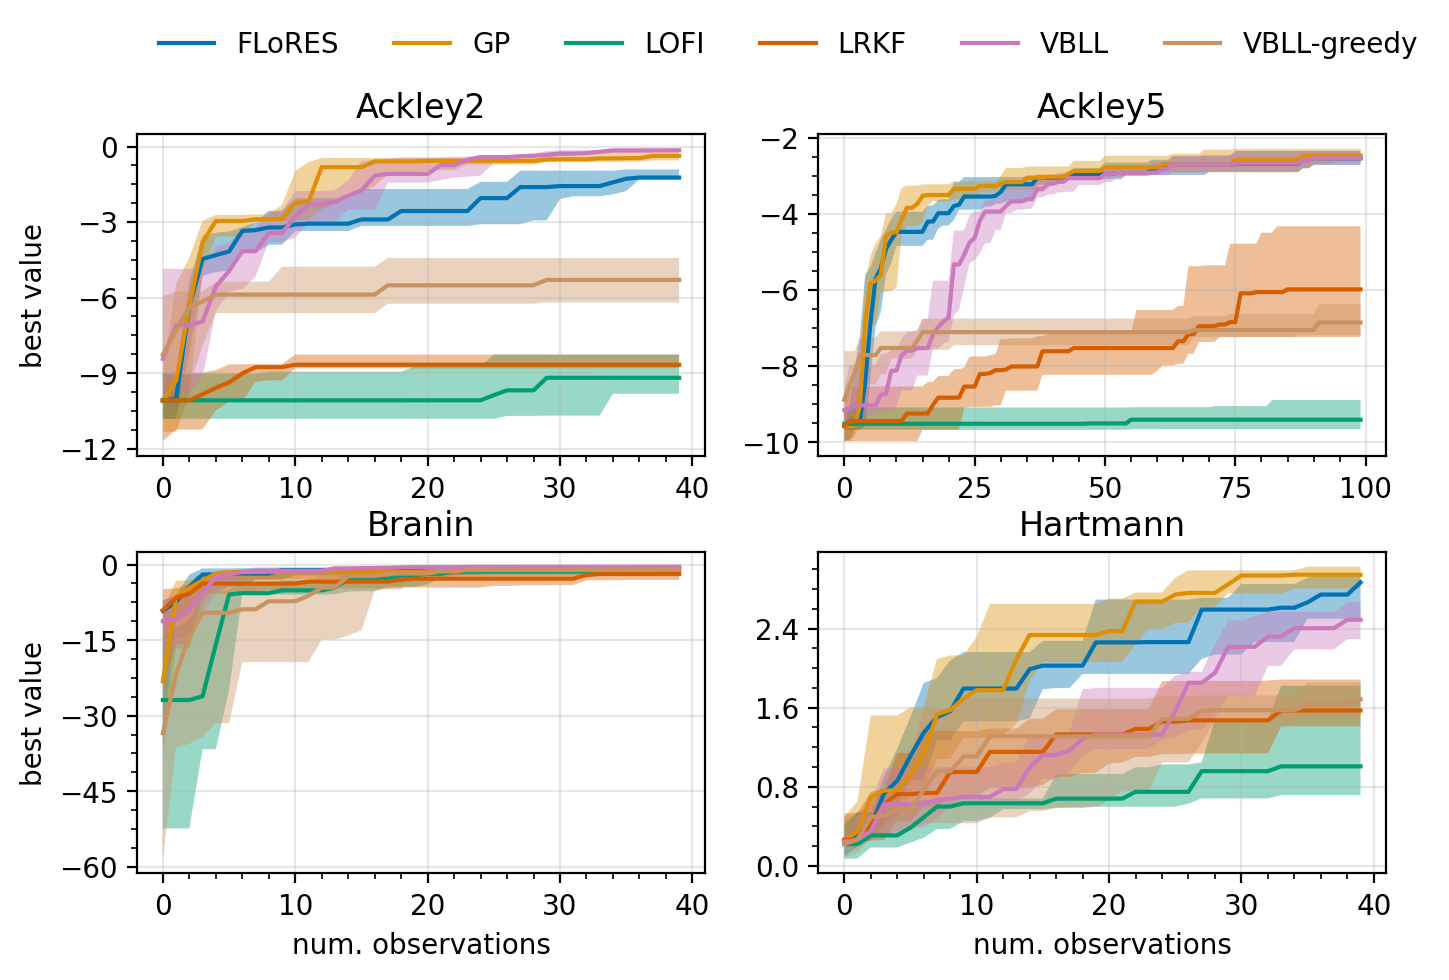

In [749]:
fig, axs = plt.subplots(2, 2, figsize=(6.2 * 1.3, 4.8))
methods = sorted(list(res["ackley2"]))

for ax, name in zip(axs.ravel(), res):
    res_experiment = res[name]
    for name_method in sorted(res_experiment):
        runs = res_experiment[name_method]
        plot_hist(ax, runs["y_best"], label=name_method)
    format_ticks(ax)
    ax.set_title(name.capitalize())
    ax.grid(alpha=0.3)
axs[0,0].legend(ncol=6, bbox_to_anchor=(2.3, 1.4), frameon=False)

axs[1,0].set_xlabel("num. observations")
axs[1,1].set_xlabel("num. observations")
axs[0,0].set_ylabel("best value")
axs[1,0].set_ylabel("best value")
plt.subplots_adjust(hspace=0.3)
plt.savefig("../figures/bayesopt-iterations.png", dpi=300, bbox_inches="tight")

In [750]:
summary = []
for ax, name in zip(axs.ravel(), res):
    res_experiment = res[name]
    for name_method in sorted(res_experiment):
        runs = res_experiment[name_method]

        summary.append({
            "y_best": runs["y_best"][:, -1].mean(),
            "time": runs["time"],
            "method": name_method,
            "experiment": name
        })
summary =pd.DataFrame(summary)

In [751]:
v = summary.query("experiment == @experiment").query("method == 'FLoRES'")

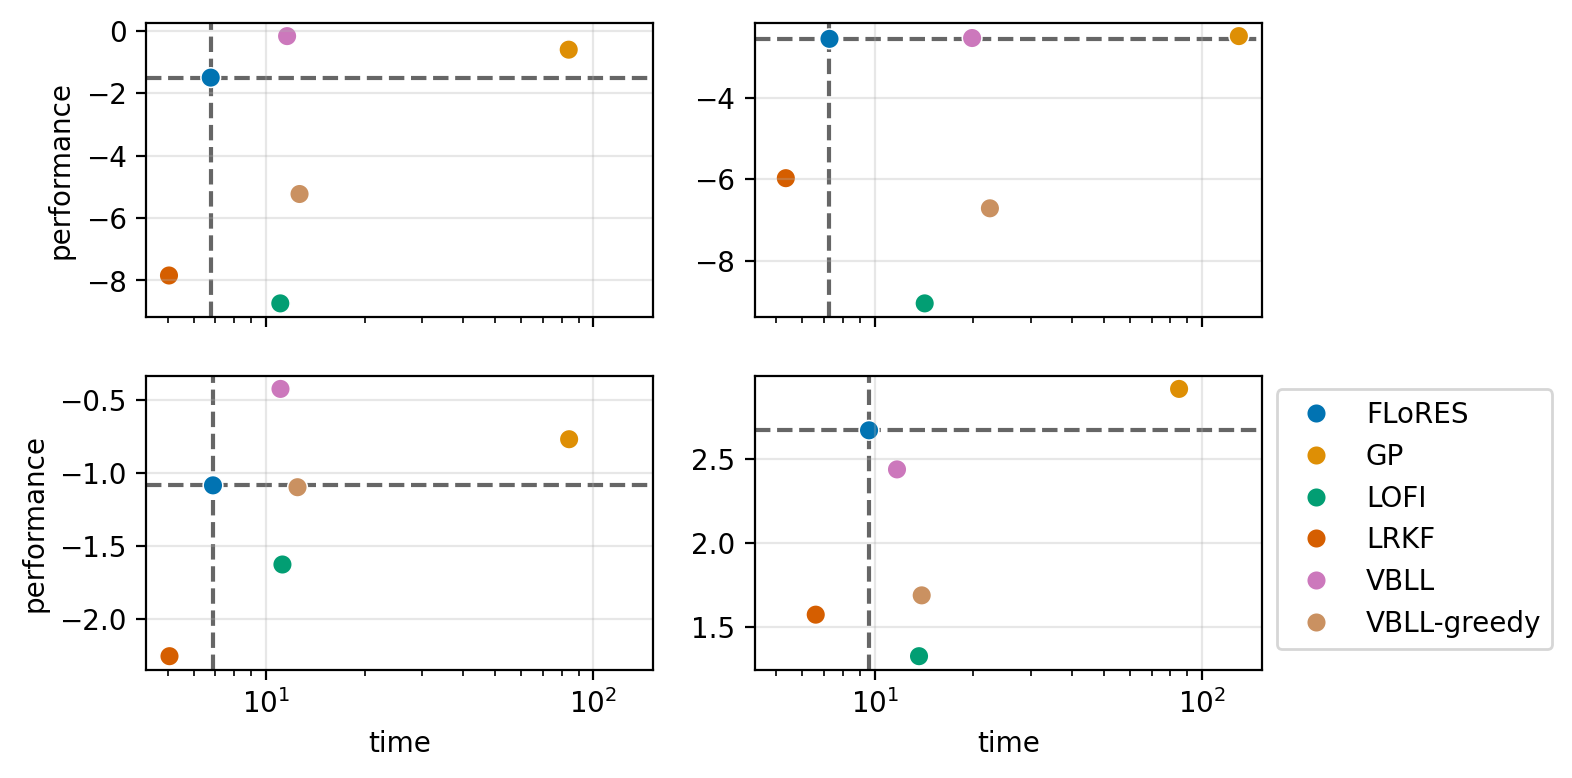

In [753]:
fig, axs = plt.subplots(2, 2, sharex=True)

experiments = summary["experiment"].unique()
for ax, experiment in zip(axs.ravel(), experiments):
    sns.scatterplot(
        x="time",
        y="y_best",
        hue="method",
        data=summary.query("experiment == @experiment"),
        ax=ax,
        s=50
    )
    
    v = summary.query("experiment == @experiment").query("method == 'FLoRES'")
    y = v["y_best"].item()
    x = v["time"].item()

    ax.axhline(y=y, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.axvline(x=x, color="black", linestyle="--", zorder=0, alpha=0.6)
    
    ax.grid(alpha=0.3)
    ax.legend([], frameon=False)
    ax.set_xscale("log")
    plt.grid(alpha=0.3)
axs[0,1].set_ylabel("")
axs[1,1].set_ylabel("")
axs[0,0].set_ylabel("performance")
axs[1,0].set_ylabel("performance")
ax.legend(bbox_to_anchor=(1.6,1))

## Ackley 1d: Gaussian process with Matern Kernel

In [348]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=-4, ubound=5)
x_test = jnp.zeros(1)
dim = len(x_test)

In [349]:
key = jax.random.PRNGKey(314)
x = jax.random.uniform(key, minval=0, maxval=1, shape=(10,))[:, None]
y = jax.vmap(objective_fn)(x)

In [343]:
x_test = jnp.linspace(0, 1, 500)[:, None]
y_test = jax.vmap(objective_fn)(x_test)

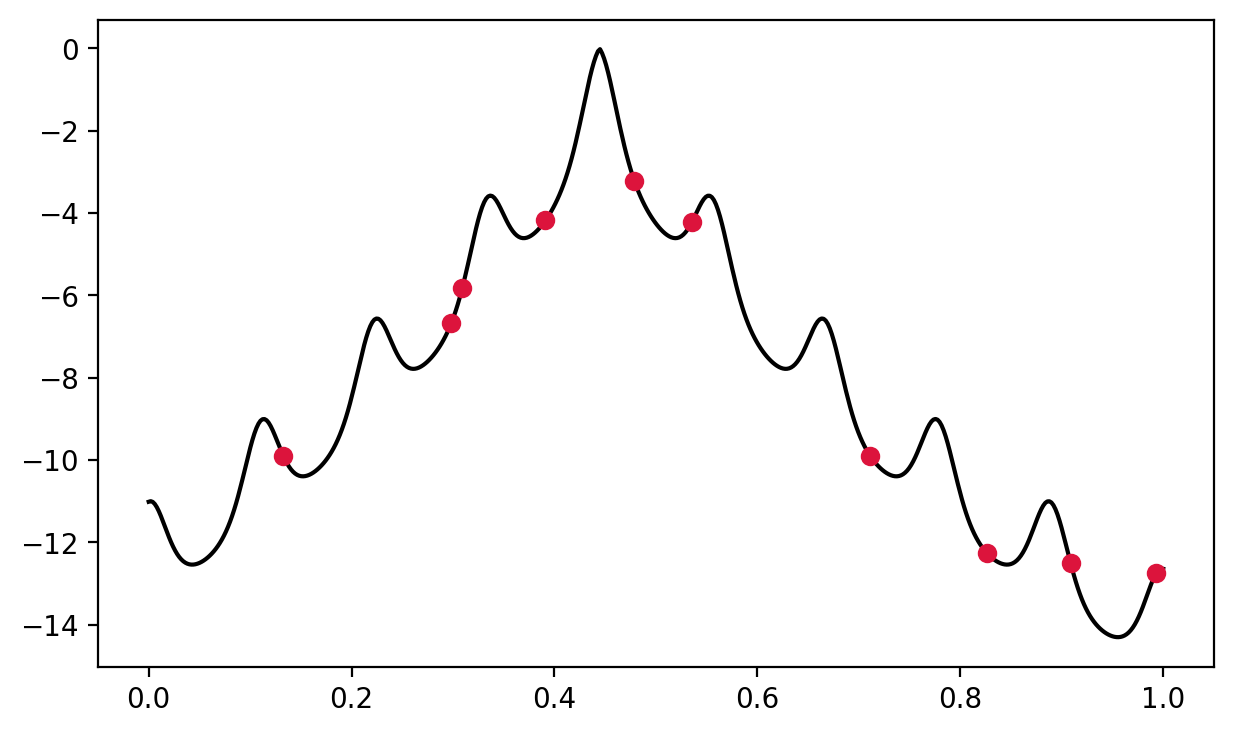

In [344]:
plt.scatter(x, y, c="crimson")
plt.plot(x_test, y_test, c="black", zorder=0)

## Bayesopt

In [64]:
from rebayes_mini.methods import gaussian_process as gp

In [65]:
keys = jax.random.split(key, 20)

In [66]:
kernel = gp.matern_kernel(length_scale=0.1, nu=5/2)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)

In [67]:
bel, _ = agent.scan(bel_init, y, x)

In [68]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x) 

y_samples = eval_fn(keys, bel, x_test).squeeze()

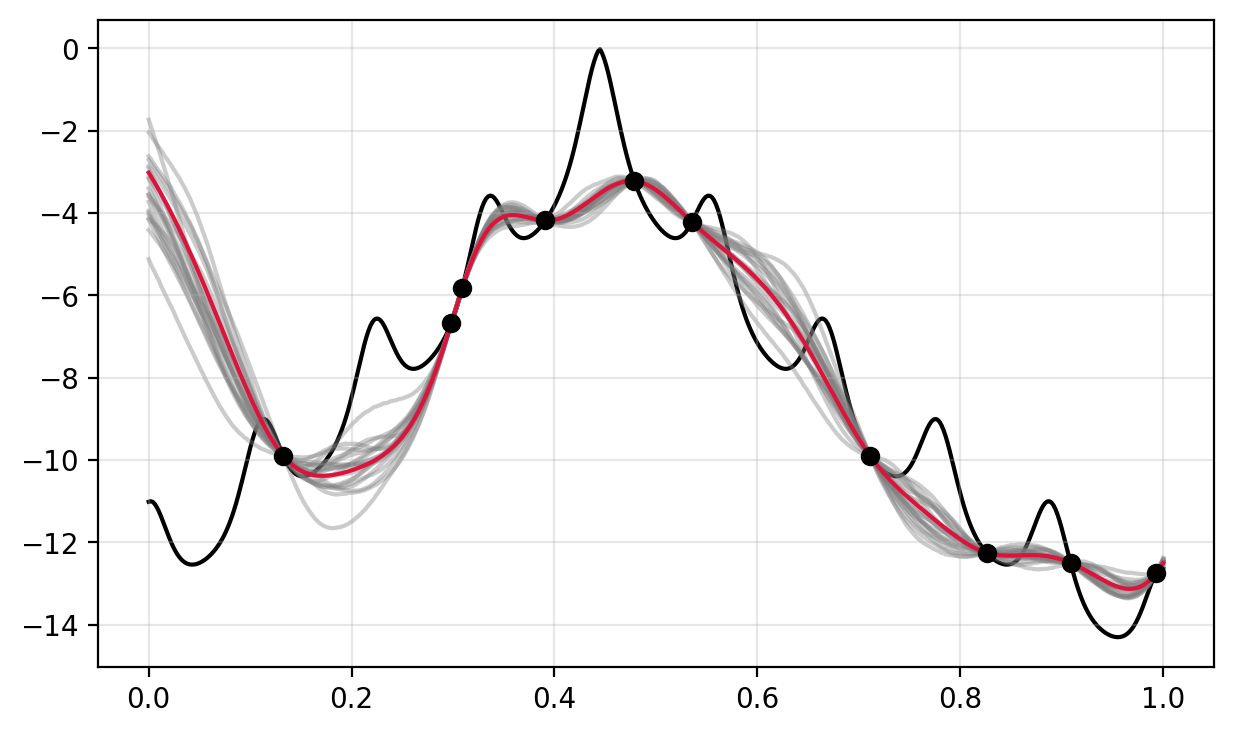

In [69]:
plt.plot(x_test, y_test, c="black", zorder=0)
plt.plot(x_test, agent.mean_fn(bel, x_test), c="crimson")
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.4, zorder=0);

In [70]:
bel_update = agent.update(bel_init, y[0], x[0])

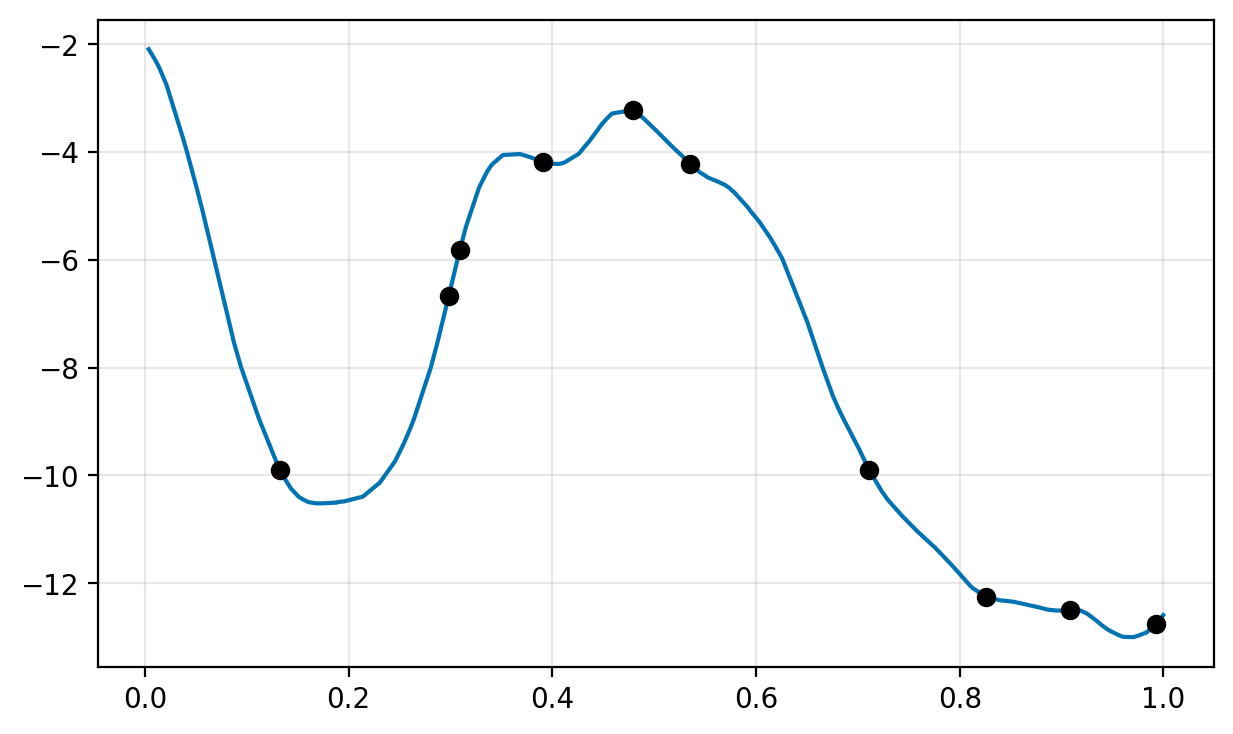

In [71]:
n_eval = 200
x_eval = jnp.sort(jax.random.uniform(key, minval=0, maxval=1, shape=(n_eval, 1)), axis=0)

fn = agent.sample_fn(key, bel)
y_eval = fn(x_eval)

plt.plot(x_eval, y_eval)
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)

# VBLL

In [72]:
import optax
from rebayes_mini.methods import replay_sgd
from flax.training.train_state import TrainState
from vbll_fifo import Regression, FifoVBLL

In [73]:
class VBLLMLP(nn.Module):
    n_hidden: int = 180

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=1 / 10.0,
        )(x)
        return x

In [74]:
vbll = VBLLMLP()
params_init = vbll.init(key_init_params, x_test[:, None])

In [75]:
def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

In [86]:
%%time
agent = FifoVBLL(
    vbll.apply,
    lossfn,
    tx=optax.adamw(1e-3),
    buffer_size=10,
    dim_features=1,
    dim_output=1,
    n_inner=10_000
)

bel_init = agent.init_bel(params_init)
bel_final, _ = agent.scan(bel_init, y, x)
bel_final = jax.block_until_ready(bel_final)

CPU times: user 2.24 s, sys: 61.3 ms, total: 2.3 s
Wall time: 8.47 s


In [87]:
fn = agent.sample_fn(key_run, bel_final)
ysampled = fn(x_test)

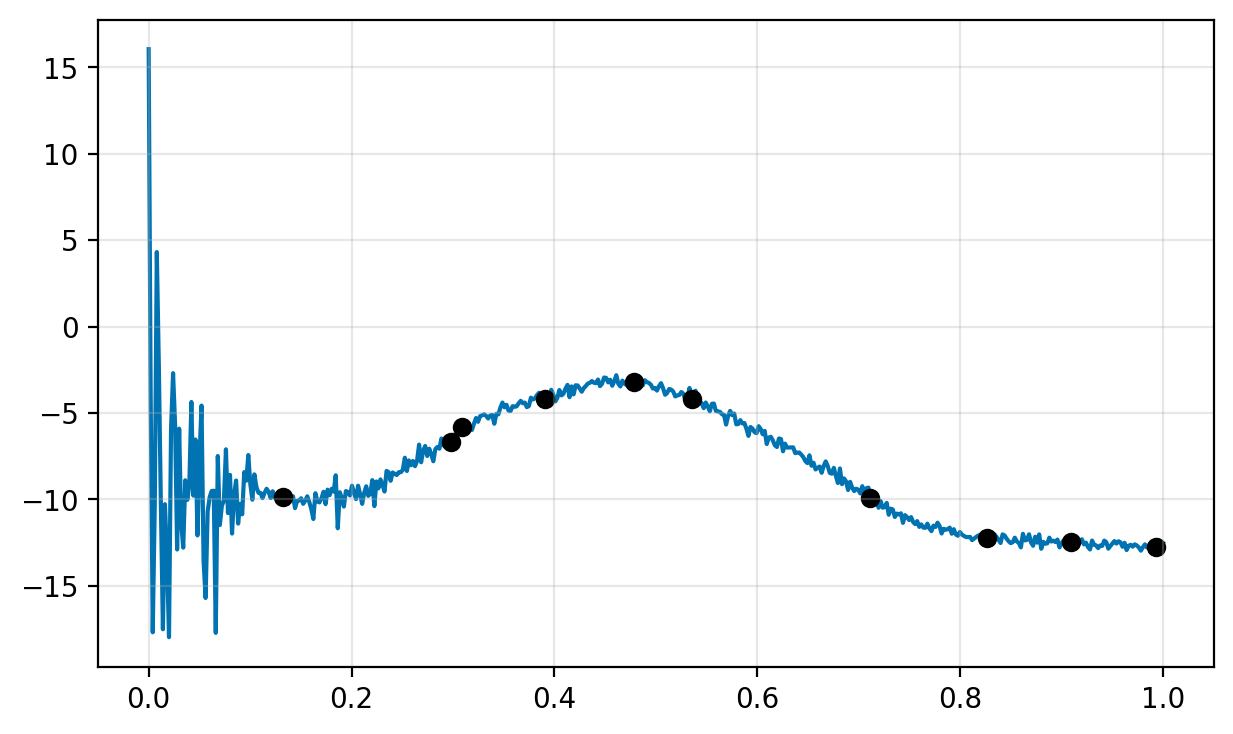

In [90]:
plt.plot(x_test, ysampled, zorder=0)
plt.scatter(x, y, c="black")
plt.grid(alpha=0.3)

In [89]:
mean = agent.mean_fn(bel_final, x_test)
sigma = jnp.sqrt(agent.cov_fn(bel_final, x_test))

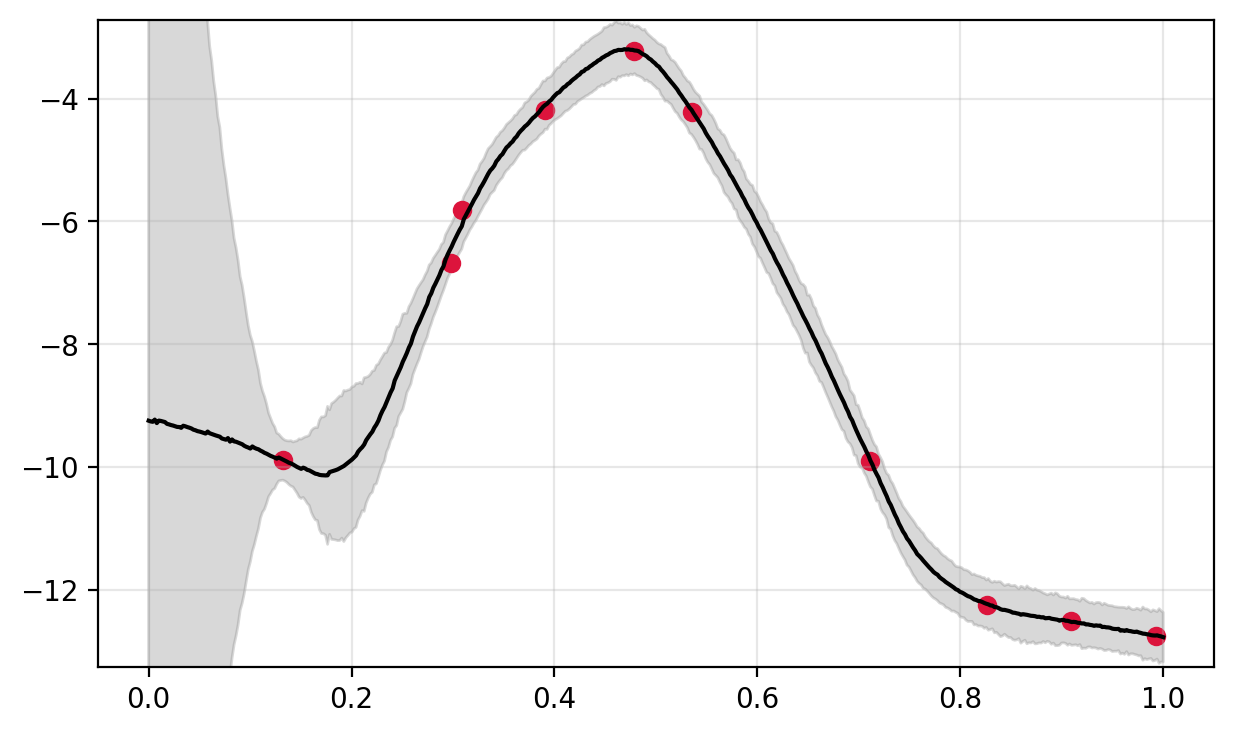

In [91]:
lbound = mean - 2 * sigma
ubound = mean + 2 * sigma

plt.plot(x_test.ravel(), mean, c="black")
ymin, ymax = plt.ylim()
plt.fill_between(x_test.ravel(), lbound, ubound, color="tab:gray", alpha=0.3)
plt.scatter(x, y, c="crimson")
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

## Simple test

In [32]:
x_test = jnp.linspace(0, 1.2, 200)[:, None]
x = jnp.array([0.1, 0.2, 0.25, 0.8, 0.9])[:, None]
y = jnp.array([1.3, 1.1, 0.9, 0.85, 0.6])

In [33]:
kernel = gp.gaussian_kernel(sigma2=0.01)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)
bel, _ = agent.scan(bel_init, y, x)

In [34]:
keys = jax.random.split(key, 20)

In [35]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x)

In [36]:
y_samples = eval_fn(keys, bel, x_test).squeeze()

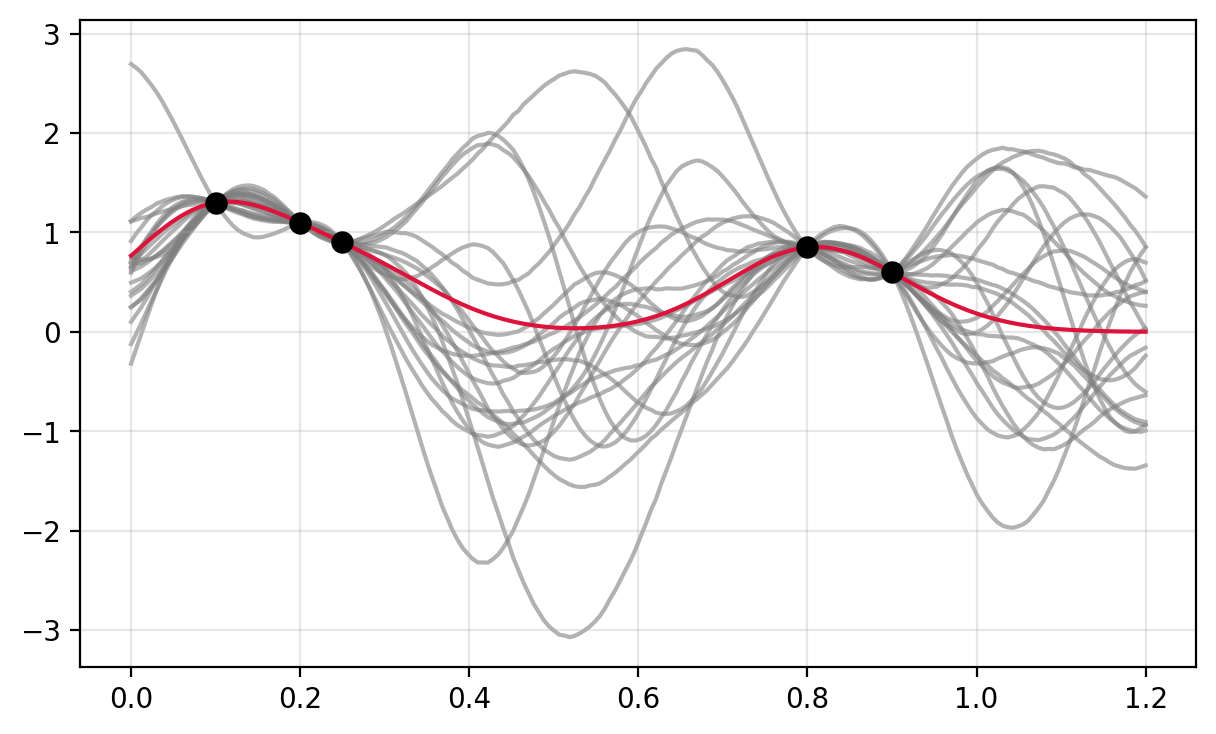

In [37]:
yhat = agent.mean_fn(bel, x_test)
plt.scatter(x, y, c="black", s=50, zorder=3)
plt.plot(x_test, yhat, c="crimson")
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.6, zorder=0)
plt.grid(alpha=0.3)